## 데이터셋 불러오기 및 약간의 전처리

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

In [24]:
import pandas as pd
df = pd.read_csv('/Users/han-yeeun/mid-project/src/storage/train_data/train250318-01_topic_merged_컬럼삭제안됨.csv', encoding='utf-8')

In [25]:
# 불필요한 컬럼 제거
df = df.drop(columns=['공고번호', '전용면적당 시세차익', '기사 번호', '주요 토픽', '미달여부'])

In [26]:
# 컬럼명 변경
df = df.rename(columns={'토픽 1' : '분양가와 대출 조건',
                        '토픽 2': '청약 경쟁률 및 순위',
                        '토픽 3': '아파트 타입 및 조건',
                        '토픽 4': '당첨 가점 및 로또 청약',
                        '토픽 5': '부동산 시장',
                        '토픽 6': '신도시 개발 및 인프라 조성',
                        '토픽 7': '청약 접수 및 아파트 면적'})

In [27]:
# 일단 경쟁률, 최저당첨가점이 0인 것을 제외
df = df[(df['경쟁률'] != 0) & (df['최저당첨가점'] != 0)]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2981 entries, 44 to 17246
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주택명                2981 non-null   object 
 1   공급지역코드             2981 non-null   int64  
 2   공급지역명              2981 non-null   object 
 3   공급위치우편번호           2981 non-null   int64  
 4   공급위치               2981 non-null   object 
 5   공급규모               2981 non-null   int64  
 6   모집공고일              2981 non-null   object 
 7   청약접수시작일            2981 non-null   object 
 8   청약접수종료일            2981 non-null   object 
 9   당첨자발표일             2981 non-null   object 
 10  투기과열지구             2981 non-null   object 
 11  조정대상지역             2981 non-null   object 
 12  분양가상한제             2981 non-null   object 
 13  정비사업               2981 non-null   object 
 14  공공주택지구             2981 non-null   object 
 15  대규모택지개발지구          2981 non-null   object 
 16  수도권내민영공공주택지구       2981 non

## 지역별 토픽 중요도 차이 분석
- 사용 변수
    - '공급지역코드'(1)
    - '분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적'(37-43)

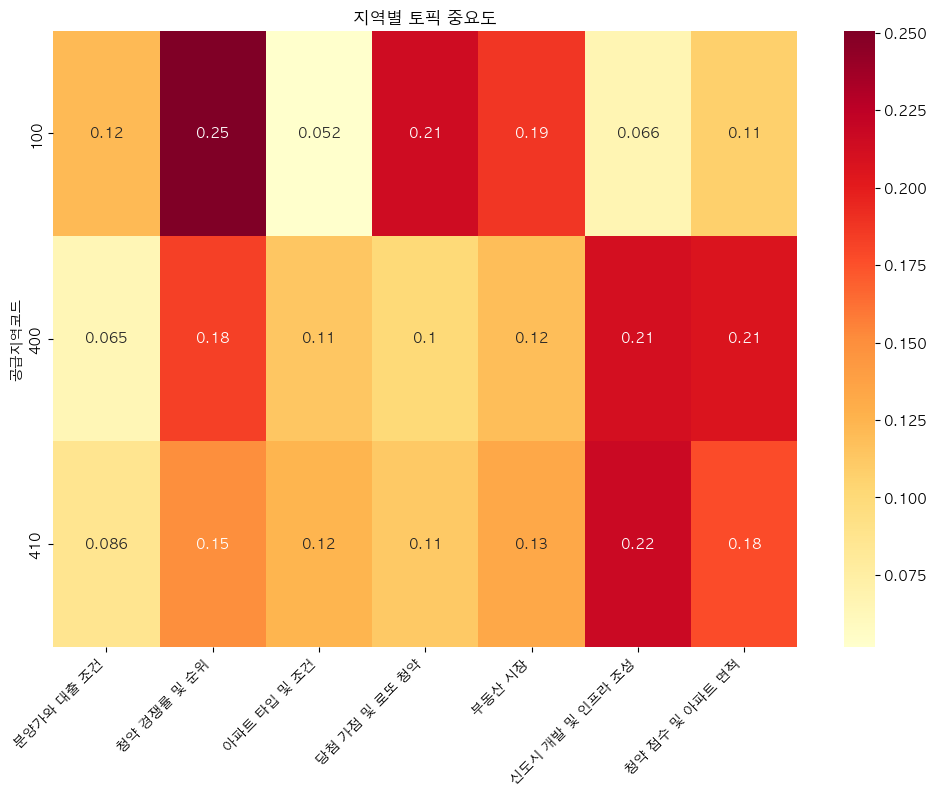

주요 토픽
신도시 개발 및 인프라 조성    2
청약 경쟁률 및 순위        1
Name: count, dtype: int64


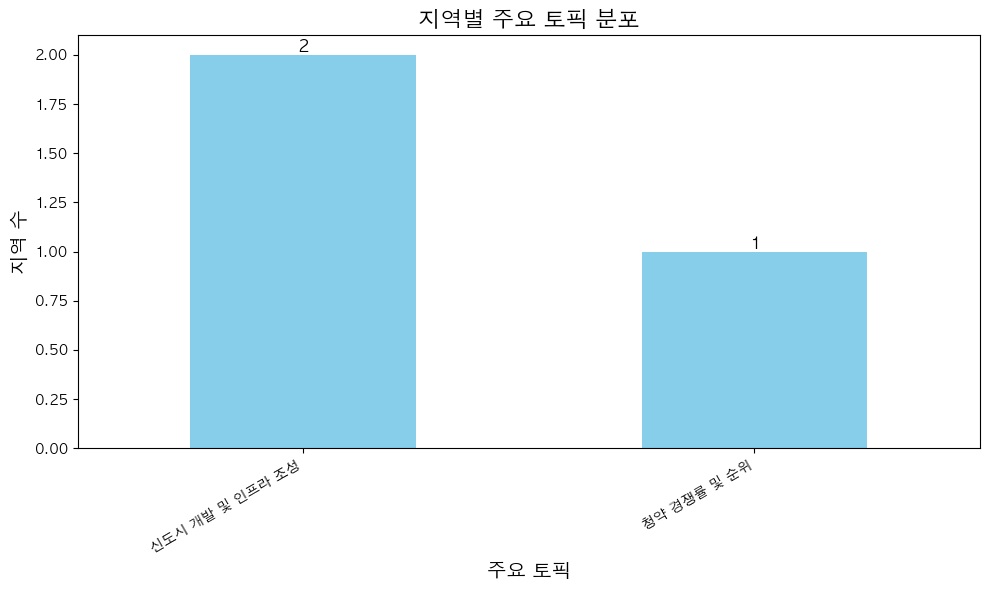

In [29]:
# 지역별 토픽 평균 계산
topic_cols = ['분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적']
region_topic_means = df.groupby('공급지역코드')[topic_cols].mean()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(region_topic_means, cmap='YlOrRd', annot=True)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('지역별 토픽 중요도')
plt.show()

# 지역별 가장 중요한 토픽 식별 및 시각화
region_topic_means['주요 토픽'] = region_topic_means.idxmax(axis=1)
topic_counts = region_topic_means['주요 토픽'].value_counts()
print(topic_counts)

# 주요 토픽 분포 시각화
plt.figure(figsize=(10, 6))
bars = topic_counts.plot(kind='bar', color='skyblue')

# 각 막대 위에 값 표시
for bar in bars.patches:
    bars.annotate(f"{bar.get_height()}", 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='bottom', fontsize=12)

plt.title('지역별 주요 토픽 분포', fontsize=16, fontweight='bold')
plt.xlabel('주요 토픽', fontsize=14)
plt.ylabel('지역 수', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

- 해석
    - 100(서울)에서는 청약 경쟁률 및 순위, 당첨 가점 및 로또 청약, 부동산 시장 순으로 중요
    - 400(인천)과 410(경기)에서는 신도시 개발 및 인프라 조성과 청약 접수 및 아파트 면적이 중요
- 결론
    - 지역별로 청약 관련 주요 관심사가 다름
        - 100(서울)은 청약 경쟁률과 당첨 가점, 400(인천)과 410(경기)은 신도시 개발과 아파트 면적에 더 관심이 있음

## 토픽 점수가 높은 물건과 낮은 물건의 특성 비교
각 토픽이 실제 청약 시장에서 어떤 특성을 가진 물건들과 연관되어 있는지 파악 가능
- 사용 변수
    - '경쟁률'(14), '최저당첨가점'(15), '공급금액(최고가 기준)'(18), '전용면적'(16)
    - '분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적'(37-43)

In [30]:
# 각 토픽별로 상위 10%와 하위 10% 물건 비교
for topic in topic_cols:
    high_score = df[df[topic] > df[topic].quantile(0.9)]
    low_score = df[df[topic] < df[topic].quantile(0.1)]
    
    print(f"\n{topic} 비교:")
    for var in ['경쟁률', '최저당첨가점', '공급금액(최고가 기준)', '전용면적']:
        high_mean = high_score[var].mean()
        low_mean = low_score[var].mean()
        print(f"{var}: 상위 10% 평균 {high_mean:.2f}, 하위 10% 평균 {low_mean:.2f}")


분양가와 대출 조건 비교:
경쟁률: 상위 10% 평균 134.61, 하위 10% 평균 29.43
최저당첨가점: 상위 10% 평균 53.21, 하위 10% 평균 44.57
공급금액(최고가 기준): 상위 10% 평균 806622770.27, 하위 10% 평균 527305864.41
전용면적: 상위 10% 평균 73.46, 하위 10% 평균 80.36

청약 경쟁률 및 순위 비교:
경쟁률: 상위 10% 평균 119.45, 하위 10% 평균 52.52
최저당첨가점: 상위 10% 평균 55.51, 하위 10% 평균 45.65
공급금액(최고가 기준): 상위 10% 평균 984822640.85, 하위 10% 평균 570211077.44
전용면적: 상위 10% 평균 78.69, 하위 10% 평균 75.94

아파트 타입 및 조건 비교:
경쟁률: 상위 10% 평균 23.24, 하위 10% 평균 66.35
최저당첨가점: 상위 10% 평균 45.34, 하위 10% 평균 49.01
공급금액(최고가 기준): 상위 10% 평균 601038945.58, 하위 10% 평균 594076707.32
전용면적: 상위 10% 평균 73.81, 하위 10% 평균 78.34

당첨 가점 및 로또 청약 비교:
경쟁률: 상위 10% 평균 324.53, 하위 10% 평균 17.73
최저당첨가점: 상위 10% 평균 62.89, 하위 10% 평균 43.35
공급금액(최고가 기준): 상위 10% 평균 948977288.14, 하위 10% 평균 623124122.14
전용면적: 상위 10% 평균 80.44, 하위 10% 평균 73.43

부동산 시장 비교:
경쟁률: 상위 10% 평균 46.22, 하위 10% 평균 65.37
최저당첨가점: 상위 10% 평균 47.75, 하위 10% 평균 50.37
공급금액(최고가 기준): 상위 10% 평균 692012081.91, 하위 10% 평균 608866617.65
전용면적: 상위 10% 평균 67.46, 하위 10% 평균 77.96

신도시 개발 및 인프라 조성 비교:


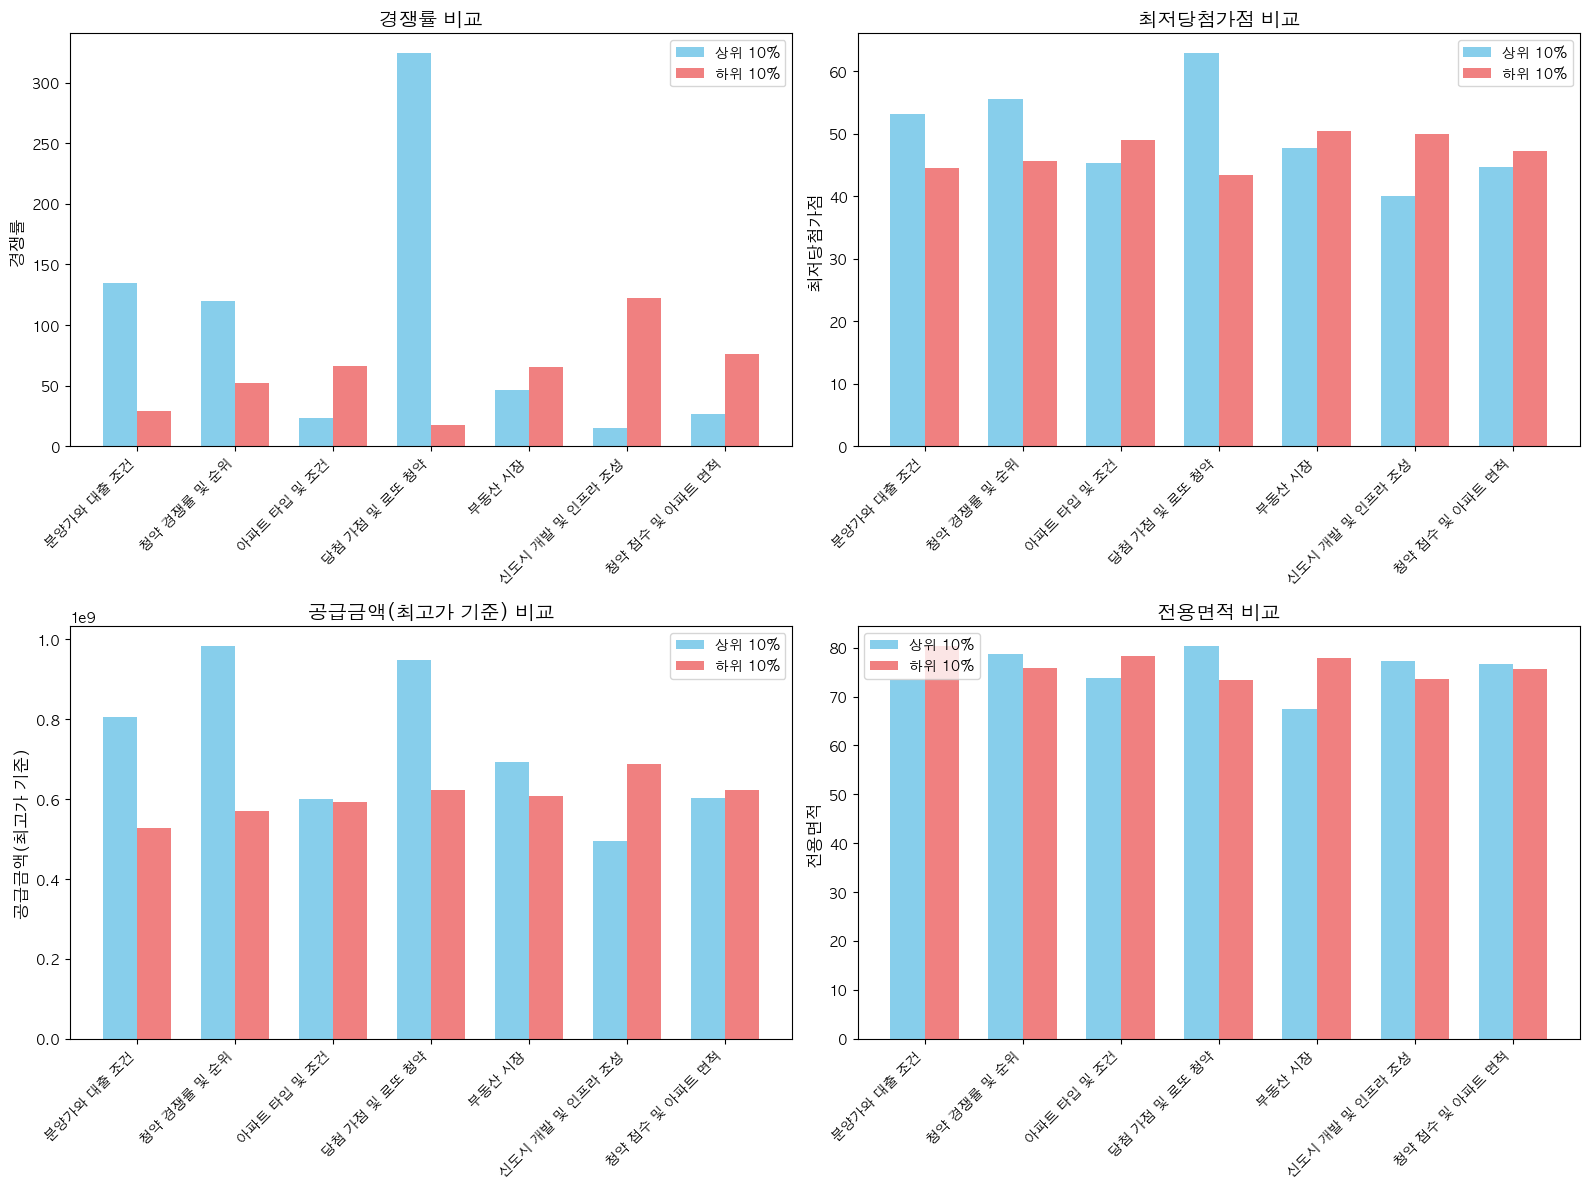

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 데이터 준비
topics = ['분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', 
          '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적']
variables = ['경쟁률', '최저당첨가점', '공급금액(최고가 기준)', '전용면적']

# 상위 10%와 하위 10% 평균값 데이터
data = {
    '분양가와 대출 조건': {'경쟁률': [134.61, 29.43], '최저당첨가점': [53.21, 44.57], 
                  '공급금액(최고가 기준)': [806622770.27, 527305864.41], '전용면적': [73.46, 80.36]},
    '청약 경쟁률 및 순위': {'경쟁률': [119.45, 52.52], '최저당첨가점': [55.51, 45.65], 
                  '공급금액(최고가 기준)': [984822640.85, 570211077.44], '전용면적': [78.69, 75.94]},
    '아파트 타입 및 조건': {'경쟁률': [23.24, 66.35], '최저당첨가점': [45.34, 49.01], 
                  '공급금액(최고가 기준)': [601038945.58, 594076707.32], '전용면적': [73.81, 78.34]},
    '당첨 가점 및 로또 청약': {'경쟁률': [324.53, 17.73], '최저당첨가점': [62.89, 43.35], 
                   '공급금액(최고가 기준)': [948977288.14, 623124122.14], '전용면적': [80.44, 73.43]},
    '부동산 시장': {'경쟁률': [46.22, 65.37], '최저당첨가점': [47.75, 50.37], 
               '공급금액(최고가 기준)': [692012081.91, 608866617.65], '전용면적': [67.46, 77.96]},
    '신도시 개발 및 인프라 조성': {'경쟁률': [15.17, 122.67], '최저당첨가점': [39.97, 50.00], 
                      '공급금액(최고가 기준)': [494257431.51, 688836680.00], '전용면적': [77.25, 73.66]},
    '청약 접수 및 아파트 면적': {'경쟁률': [26.90, 75.80], '최저당첨가점': [44.67, 47.16], 
                     '공급금액(최고가 기준)': [603825659.72, 623541535.43], '전용면적': [76.75, 75.70]}
}

# 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    top_values = [data[topic][var][0] for topic in topics]
    bottom_values = [data[topic][var][1] for topic in topics]
    
    x = np.arange(len(topics))
    width = 0.35
    
    axes[i].bar(x - width/2, top_values, width, label='상위 10%', color='skyblue')
    axes[i].bar(x + width/2, bottom_values, width, label='하위 10%', color='lightcoral')
    
    axes[i].set_title(f'{var} 비교', fontsize=14)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(topics, rotation=45, ha='right')
    axes[i].set_ylabel(var, fontsize=12)
    axes[i].legend()

plt.tight_layout()
plt.show()

- 해석
- 분양가와 대출 조건
    - 높은 경쟁률: 상위 10% 물건의 평균 경쟁률이 134.61로 매우 높음
    - 높은 당첨가점: 상위 10% 물건의 평균 최저당첨가점이 53.21로 높음
    - 가격 차이 큼: 상위 10%와 하위 10% 간 공급금액 차이가 약 2.8억원으로 큼
    - 분양가와 대출 조건이 중요한 물건일수록 경쟁이 치열하고 가격이 높음
- 청약 경쟁률 및 순위
    - 높은 경쟁률: 상위 10% 물건의 평균 경쟁률이 119.45로 높음
    - 높은 당첨가점: 상위 10% 물건의 평균 최저당첨가점이 55.51로 높음
    - 가장 비싼 물건: 상위 10% 물건의 평균 공급금액이 9.8억원으로 가장 높음
    - 청약 경쟁률 관련 토픽이 많이 언급된 물건은 실제로도 경쟁이 치열함
- 아파트 타입 및 조건
    - 낮은 경쟁률: 상위 10% 물건의 평균 경쟁률이 23.24로 낮음
    - 하위 10%가 높은 경쟁률: 하위 10% 물건의 경쟁률(66.35)이 상위 10%(23.24)보다 훨씬 높음
    - 중저가 물건: 평균 공급금액이 6억원 수준으로 중간~낮은 편
    - 아파트 타입과 조건이 많이 언급된 물건은 오히려 덜 인기 있는 경향
- 당첨 가점 및 로또 청약
    - 압도적으로 높은 경쟁률: 상위 10% 물건의 평균 경쟁률이 324.53으로 가장 높음
    - 최고 당첨가점: 상위 10% 물건의 평균 최저당첨가점이 62.89로 가장 높음
    - 고가 물건: 평균 공급금액이 9.5억원 수준으로 높은 편
    - 이 토픽 점수가 높은 물건은 "로또 청약"이라 불릴 만큼 극도로 경쟁이 치열함
- 부동산 시장
    - 중간 수준 경쟁률: 상위 10% 물건의 평균 경쟁률이 46.22로 중간 수준
    - 하위 10%가 더 높은 경쟁률: 하위 10% 물건의 경쟁률(65.37)이 상위 10%(46.22)보다 높음
    - 가장 작은 전용면적: 상위 10% 물건의 평균 전용면적이 67.46㎡로 가장 작음
    - 부동산 시장 관련 토픽이 많이 언급된 물건은 소형 평형대가 많음
- 신도시 개발 및 인프라 조성
    - 가장 낮은 경쟁률: 상위 10% 물건의 평균 경쟁률이 15.17로 가장 낮음
    - 하위 10%가 매우 높은 경쟁률: 하위 10% 물건의 경쟁률(122.67)이 상위 10%(15.17)보다 8배 이상 높음
    - 가장 낮은 공급금액: 평균 공급금액이 4.9억원으로 가장 낮음
    - 신도시 개발 관련 토픽이 많이 언급된 물건은 가격이 저렴하고 경쟁이 매우 낮음
- 청약 접수 및 아파트 면적
    - 낮은 경쟁률: 상위 10% 물건의 평균 경쟁률이 26.90으로 낮음
    - 하위 10%가 높은 경쟁률: 하위 10% 물건의 경쟁률(75.80)이 상위 10%(26.90)보다 훨씬 높음
    - 중저가 물건: 평균 공급금액이 6억원 수준으로 중간~낮은 편
    - 청약 접수와 아파트 면적에 관한 토픽이 많이 언급된 물건은 경쟁이 덜함

## 토픽 간 상관관계 및 상호작용 효과 분석
- 사용 변수
    - '경쟁률'(14)
    - '분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적'(37-43)

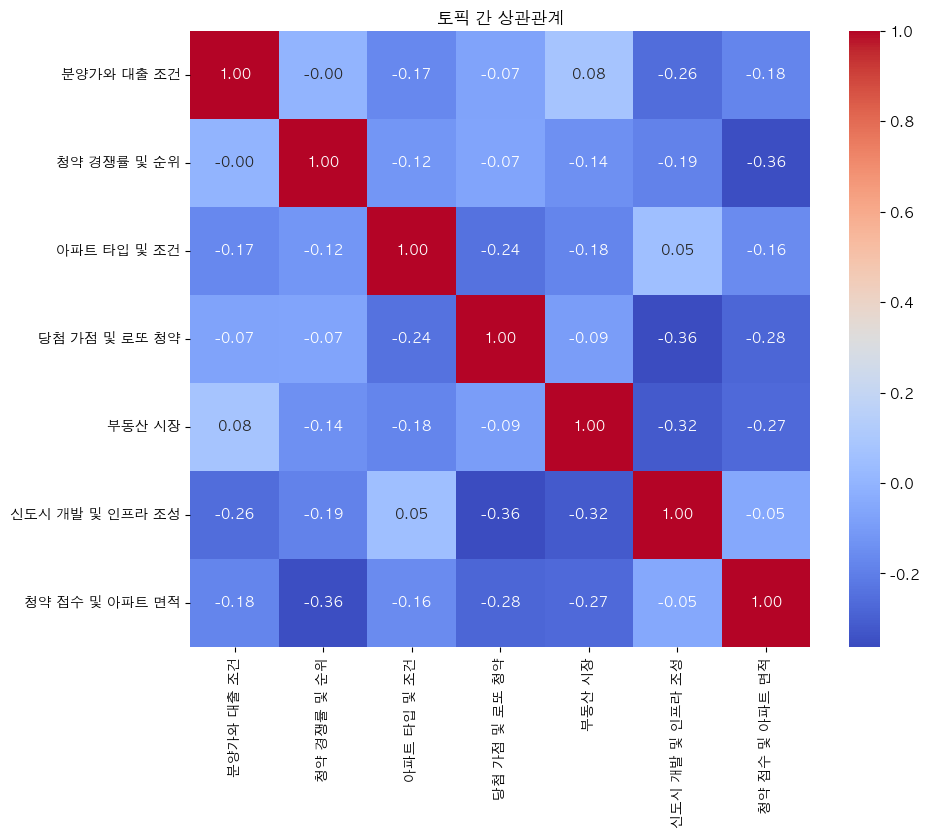

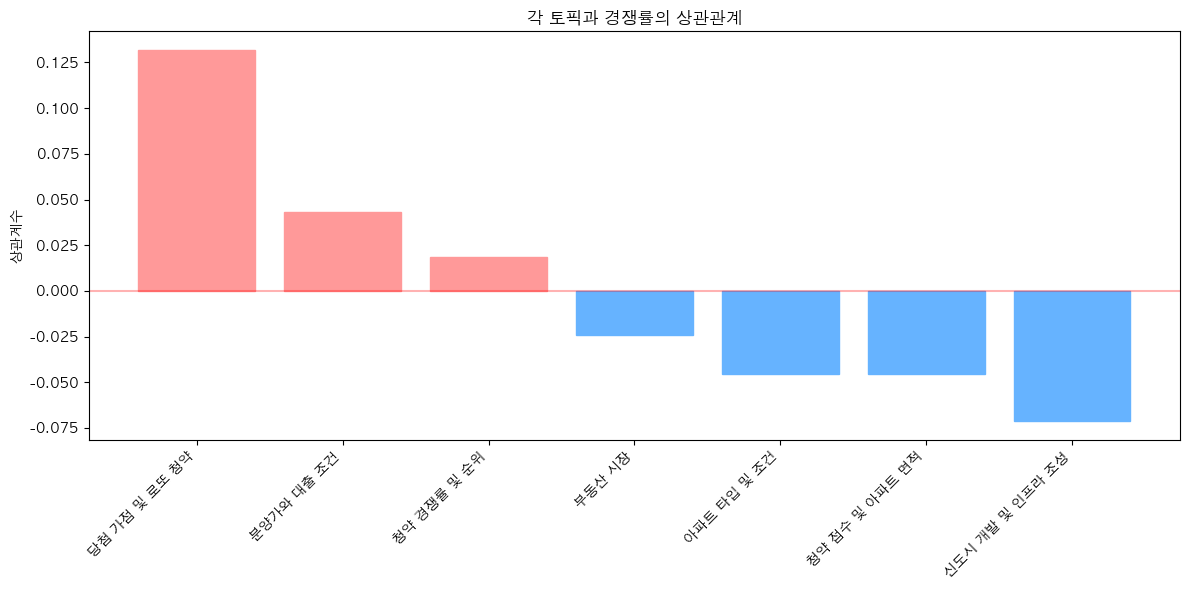

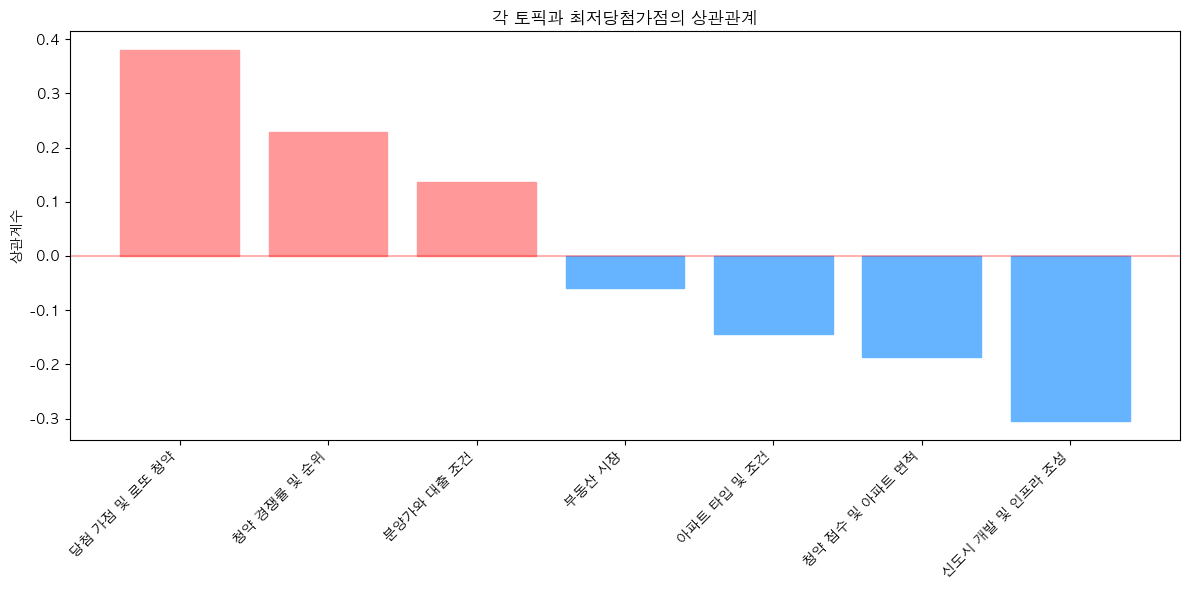

분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용과 경쟁률의 상관계수: 0.1683
저경쟁 토픽의 합산 점수와 경쟁률의 상관계수: -0.0987
분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용과 최저당점가점의 상관계수: 0.3094
저경쟁 토픽의 합산 점수와 최저당첨가점의 상관계수: -0.3918


In [33]:
# 토픽 간 상관관계 분석
topic_cols = ['분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적']
topic_corr = df[topic_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(topic_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('토픽 간 상관관계')
plt.show()

# 토픽과 경쟁률의 상관관계 분석
corr_with_competition = []
for topic in topic_cols:
    corr = np.corrcoef(df[topic], df['경쟁률'])[0, 1]
    corr_with_competition.append({
        '토픽': topic,
        '경쟁률과의 상관계수': corr
    })

corr_df = pd.DataFrame(corr_with_competition).sort_values('경쟁률과의 상관계수', ascending=False)

# 경쟁률과의 상관관계 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(corr_df['토픽'], corr_df['경쟁률과의 상관계수'], color='skyblue')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('각 토픽과 경쟁률의 상관관계')
plt.xticks(rotation=45, ha='right')
plt.ylabel('상관계수')
plt.tight_layout()

# 양수/음수 값에 따라 색상 구분
for i, bar in enumerate(bars):
    if corr_df.iloc[i]['경쟁률과의 상관계수'] > 0:
        bar.set_color('#ff9999')  # 양의 상관관계는 빨간색 계열
    else:
        bar.set_color('#66b3ff')  # 음의 상관관계는 파란색 계열
plt.show()

# 토픽과 최저당첨가점의 상관관계 분석
corr_with_points = []
for topic in topic_cols:
    corr = np.corrcoef(df[topic], df['최저당첨가점'])[0, 1]
    corr_with_points.append({
        '토픽': topic,
        '최저당첨가점과의 상관계수': corr
    })

corr_points_df = pd.DataFrame(corr_with_points).sort_values('최저당첨가점과의 상관계수', ascending=False)

# 최저당첨가점과의 상관관계 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(corr_points_df['토픽'], corr_points_df['최저당첨가점과의 상관계수'], color='skyblue')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('각 토픽과 최저당첨가점의 상관관계')
plt.xticks(rotation=45, ha='right')
plt.ylabel('상관계수')
plt.tight_layout()

# 양수/음수 값에 따라 색상 구분
for i, bar in enumerate(bars):
    if corr_points_df.iloc[i]['최저당첨가점과의 상관계수'] > 0:
        bar.set_color('#ff9999')  # 양의 상관관계는 빨간색 계열
    else:
        bar.set_color('#66b3ff')  # 음의 상관관계는 파란색 계열
plt.show()

# 토픽 간 상호작용 효과 분석
# 분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용 분석
df['고경쟁_토픽_상호작용'] = df['분양가와 대출 조건'] * df['당첨 가점 및 로또 청약']
interaction_effect = np.corrcoef(df['고경쟁_토픽_상호작용'], df['경쟁률'])[0, 1]
print(f"분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용과 경쟁률의 상관계수: {interaction_effect:.4f}")

# 토픽 3, 6, 7의 합산 점수와 경쟁률의 관계 분석
df['저경쟁_토픽_합산'] = df['아파트 타입 및 조건'] + df['신도시 개발 및 인프라 조성'] + df['청약 접수 및 아파트 면적']
low_comp_effect = np.corrcoef(df['저경쟁_토픽_합산'], df['경쟁률'])[0, 1]
print(f"저경쟁 토픽의 합산 점수와 경쟁률의 상관계수: {low_comp_effect:.4f}")

# 분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용 분석
df['고경쟁_토픽_상호작용'] = df['분양가와 대출 조건'] * df['당첨 가점 및 로또 청약']
interaction_effect = np.corrcoef(df['고경쟁_토픽_상호작용'], df['최저당첨가점'])[0, 1]
print(f"분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용과 최저당점가점의 상관계수: {interaction_effect:.4f}")

# 토픽 3, 6, 7의 합산 점수와 최저당첨가점의 관계 분석
df['저경쟁_토픽_합산'] = df['아파트 타입 및 조건'] + df['신도시 개발 및 인프라 조성'] + df['청약 접수 및 아파트 면적']
low_comp_effect = np.corrcoef(df['저경쟁_토픽_합산'], df['최저당첨가점'])[0, 1]
print(f"저경쟁 토픽의 합산 점수와 최저당첨가점의 상관계수: {low_comp_effect:.4f}")

- 해석
    - 토픽 간 상관관계
        - 대부분의 토픽 간에는 약한 음의 상관관계
            - 신도시 개발과 부동산 시장
            - 청약 경쟁률과 청약 접수 및 아파트 면적
    - 토픽과 경쟁률의 관계
        - 당첨 가점 및 로또 청약이 경쟁률과 토픽 중 가장 강한 양의 상관관계
        - 분양가와 대출 조건과 청약 경쟁률 및 순위도 경쟁률과 양의 상관관계
        - 나머지 토픽들은 경쟁률과 음의 상관관계
    - 토픽별 특성 비교
        - 당첨 가점 및 로또 청약 토픽이 높은 물건은 압도적으로 높은 경쟁률(약 324)
        - 신도시 개발 토픽이 높은 물건은 매우 낮은 경쟁률(약 15)
        - 최저당첨가점 비교: 당첨 가점 및 로또 청약 토픽이 높은 물건은 가장 높은 최저당첨가점(약 63)
        - 공급금액 비교: 청약 경쟁률 및 순위 토픽과 당첨 가점 및 로또 청약 토픽이 높은 물건은 가장 높은 공급금액
- 추가 분석 결과 해석
    - 분양가와 대출 조건과 당첨 가점 및 로또 청약의 상호작용과 경쟁률/최저당첨가점
        - 분양가/대출 조건과 당첨 가점/로또 청약이 함께 중요한 물건일수록 경쟁률/최저당첨가점이 높아지는 경향이 있음(최저당첨가점과의 상관관계가 더 강하게 나타남)
        - 개별 토픽의 상관계수(당첨 가점: 0.10, 분양가: 0.037)보다 상호작용의 상관계수가 더 높아, 두 토픽이 결합될 때 시너지 효과가 있음
        - 저경쟁 토픽의 합산 점수와 경쟁률/최저당첨가점
            - 아파트 타입 및 조건, 신도시 개발, 청약 접수 및 아파트 면적의 합산 점수가 중요한 물건일수록 경쟁률/최저당첨가점이 낮아지는 경향이 있음(최저당첨가점과의 상관관계가 더 강하게 나타남)
    - 당첨 가능성을 높이려면 신도시 개발, 아파트 타입 및 조건, 청약 접수 및 아파트 면적을 노리는 것이 효과적일 수 있음

## 토픽 점수와 기존 변수를 활용한 군집 분석으로 청약 시장 세분화
- 사용 변수
    - '공급규모'(2), '공급세대수'(10), '전용면적'(16), '공급금액(최고가 기준)'(18)
    - '분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', '청약 접수 및 아파트 면적'(37-43)

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 군집화에 사용할 변수 선택
cluster_vars = topic_cols + ['공급규모', '공급세대수', '전용면적', '공급금액(최고가 기준)']

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cluster_vars])

# K-means 군집화
kmeans = KMeans(n_clusters=5, random_state=42)
df['군집'] = kmeans.fit_predict(scaled_data)

# 군집별 특성 확인
print(df.groupby('군집')[cluster_vars].mean())

    분양가와 대출 조건  청약 경쟁률 및 순위  아파트 타입 및 조건  당첨 가점 및 로또 청약    부동산 시장  \
군집                                                                  
0     0.055664     0.056896     0.056510       0.055587  0.066529   
1     0.051049     0.168333     0.072587       0.044933  0.073149   
2     0.082576     0.291380     0.035360       0.398112  0.082289   
3     0.185537     0.198052     0.048091       0.108100  0.332710   
4     0.043770     0.171773     0.371472       0.069690  0.096206   

    신도시 개발 및 인프라 조성  청약 접수 및 아파트 면적        공급규모      공급세대수       전용면적  \
군집                                                                      
0          0.131071        0.577730  393.568849  33.593679  75.338598   
1          0.454606        0.135342  799.987860  67.623672  76.763087   
2          0.048069        0.062221  784.042857  53.330159  87.022035   
3          0.060454        0.067064  384.164179  28.572139  66.694668   
4          0.157211        0.089897  649.285393  69.979775  73.976099   

    

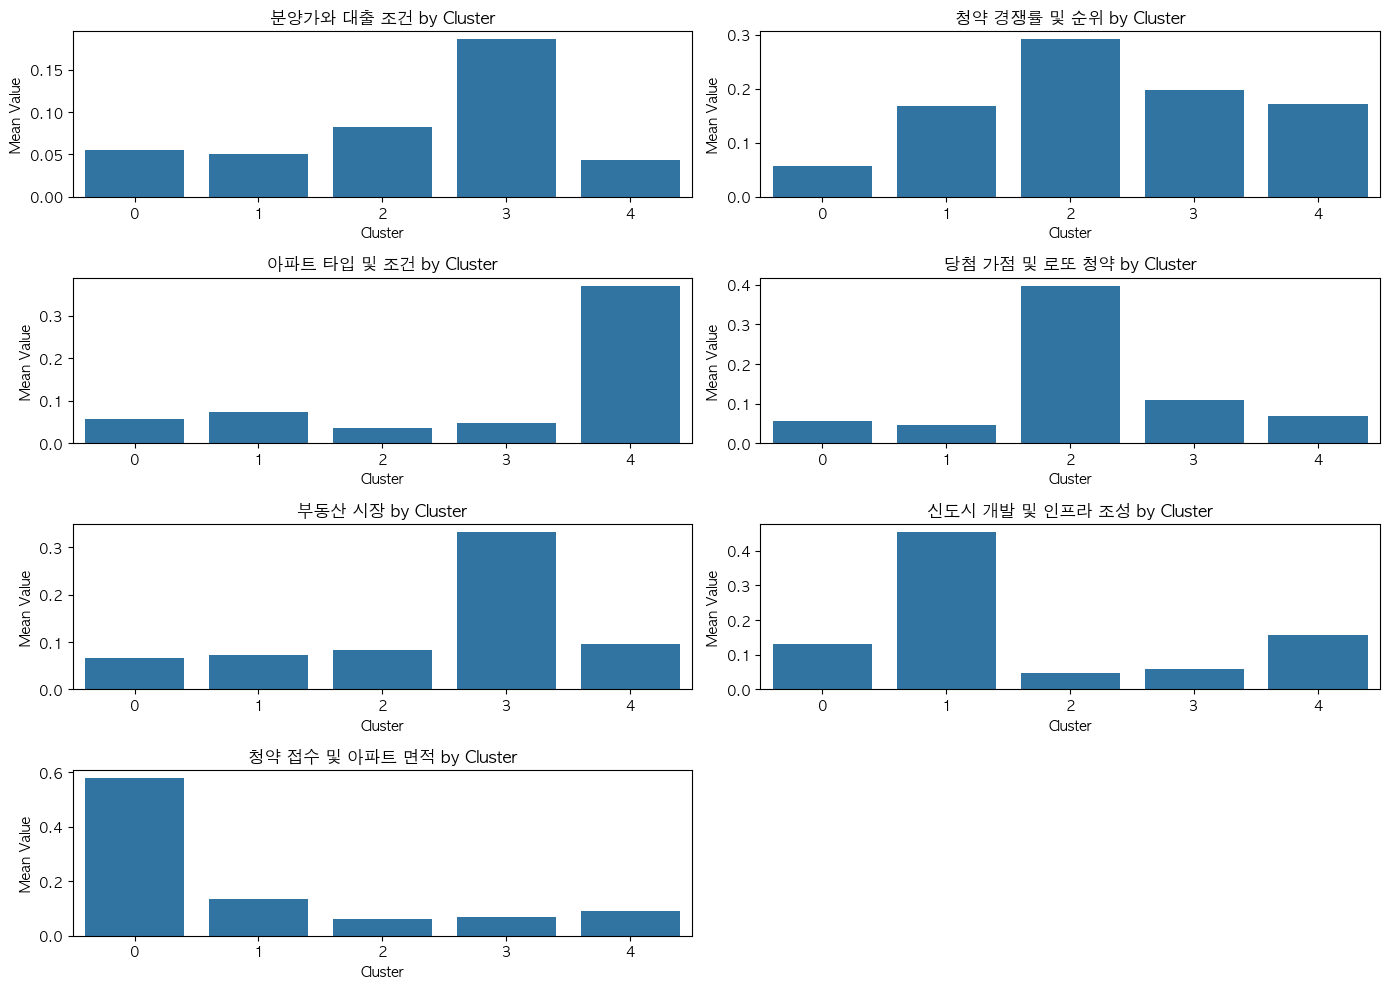

<Figure size 1200x800 with 0 Axes>

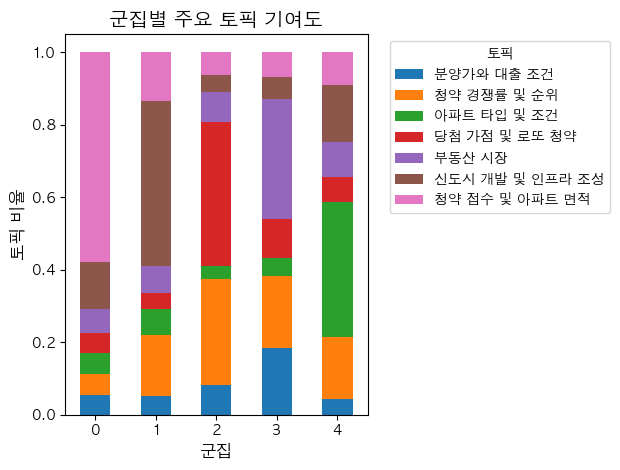

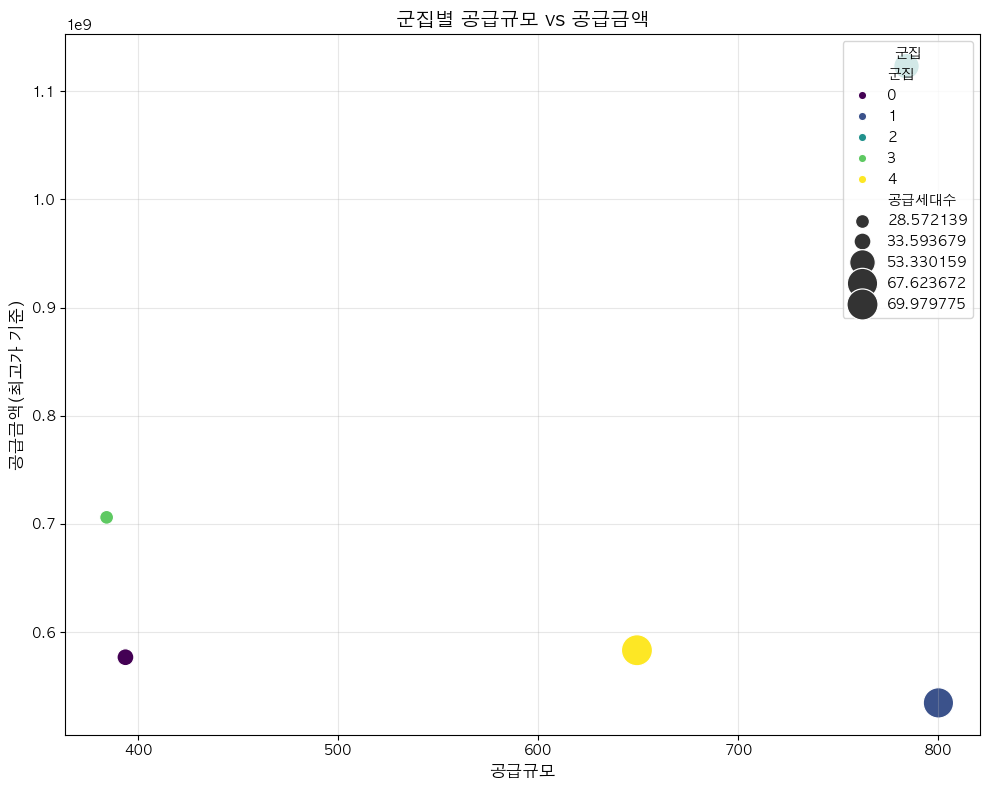

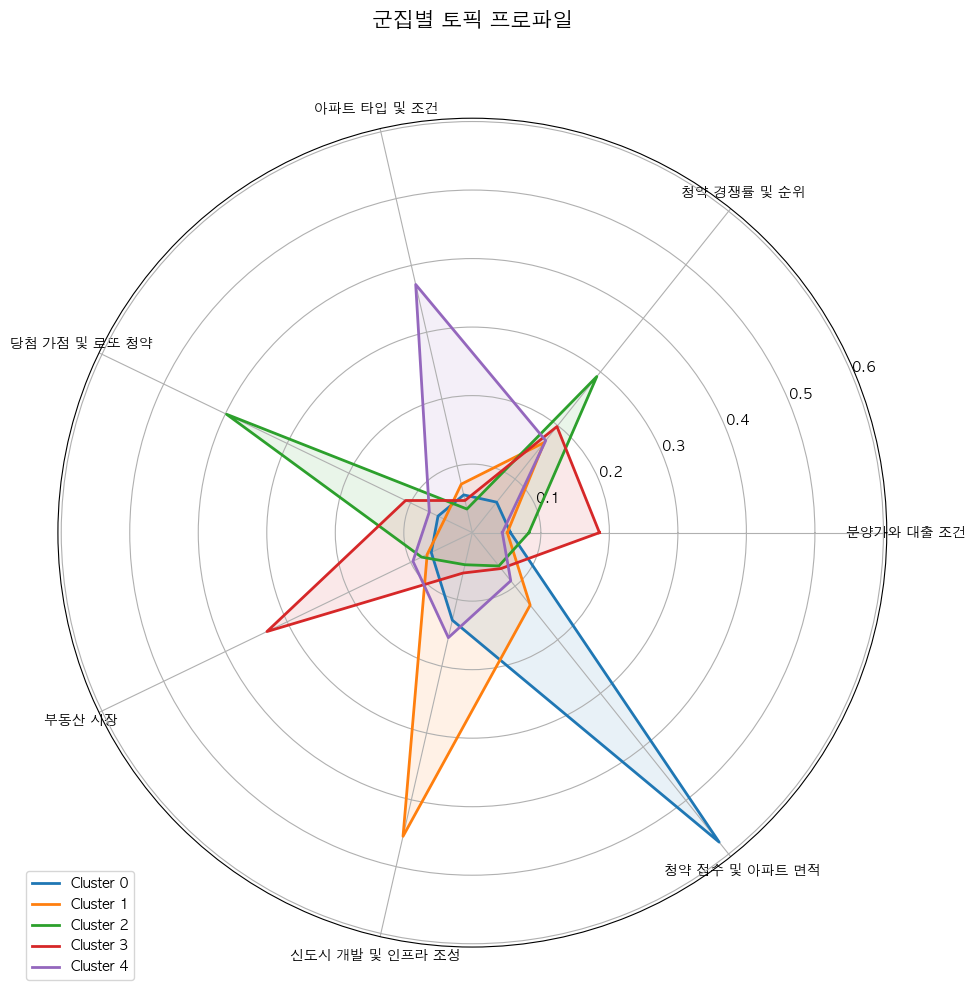

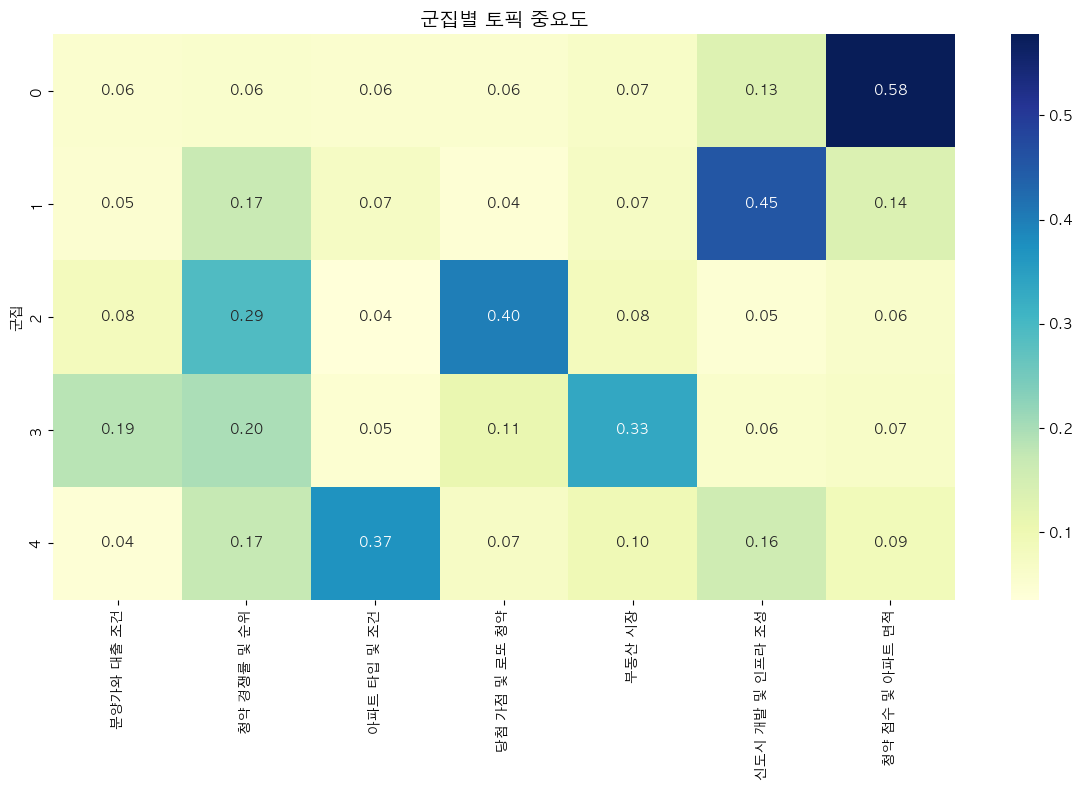

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 군집별 토픽 평균값 데이터 (K-means 결과)
cluster_data = pd.DataFrame({
    '군집': [0, 1, 2, 3, 4],
    '분양가와 대출 조건': [0.055664, 0.051049, 0.082576, 0.185537, 0.043770],
    '청약 경쟁률 및 순위': [0.056896, 0.168333, 0.291380, 0.198052, 0.171773],
    '아파트 타입 및 조건': [0.056510, 0.072587, 0.035360, 0.048091, 0.371472],
    '당첨 가점 및 로또 청약': [0.055587, 0.044933, 0.398112, 0.108100, 0.069690],
    '부동산 시장': [0.066529, 0.073149, 0.082289, 0.332710, 0.096206],
    '신도시 개발 및 인프라 조성': [0.131071, 0.454606, 0.048069, 0.060454, 0.157211],
    '청약 접수 및 아파트 면적': [0.577730, 0.135342, 0.062221, 0.067064, 0.089897],
    '공급규모': [393.568849, 799.987860, 784.042857, 384.164179, 649.285393],
    '공급세대수': [33.593679, 67.623672, 53.330159, 28.572139, 69.979775],
    '전용면적': [75.338598, 76.763087, 87.022035, 66.694668, 73.976099],
    '공급금액(최고가 기준)': [576864700, 534665700, 1123114000, 706132200, 583321300]
})

# 1. 군집별 토픽 특성 시각화 (막대 그래프)
topic_cols = ['분양가와 대출 조건', '청약 경쟁률 및 순위', '아파트 타입 및 조건', 
              '당첨 가점 및 로또 청약', '부동산 시장', '신도시 개발 및 인프라 조성', 
              '청약 접수 및 아파트 면적']

plt.figure(figsize=(14, 10))
for i, topic in enumerate(topic_cols):
    plt.subplot(4, 2, i+1)
    sns.barplot(x='군집', y=topic, data=cluster_data)
    plt.title(f'{topic} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Mean Value')
plt.tight_layout()
plt.show()

# 2. 군집별 주요 토픽 기여도 (누적 막대 그래프)
plt.figure(figsize=(12, 8))
cluster_data.set_index('군집')[topic_cols].plot(kind='bar', stacked=True)
plt.title('군집별 주요 토픽 기여도', fontsize=14)
plt.xlabel('군집', fontsize=12)
plt.ylabel('토픽 비율', fontsize=12)
plt.legend(title="토픽", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. 군집별 공급 특성 시각화 (산점도)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='공급규모', 
    y='공급금액(최고가 기준)', 
    hue='군집',
    size='공급세대수', 
    sizes=(100, 500),
    palette='viridis',
    data=cluster_data
)
plt.title('군집별 공급규모 vs 공급금액', fontsize=14)
plt.xlabel('공급규모', fontsize=12)
plt.ylabel('공급금액(최고가 기준)', fontsize=12)
plt.legend(title="군집", loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 레이더 차트로 군집별 토픽 프로파일 시각화
def radar_chart(df, categories, group_col, group_names, title):
    # 각도 계산
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 그래프를 닫기 위해 첫 각도 추가
    
    # 그래프 설정
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # 각 군집별 데이터 플롯
    for i, group in enumerate(group_names):
        values = df[df[group_col] == group][categories].values.flatten().tolist()
        values += values[:1]  # 그래프를 닫기 위해 첫 값 추가
        ax.plot(angles, values, linewidth=2, label=f'Cluster {group}')
        ax.fill(angles, values, alpha=0.1)
    
    # 축 레이블 설정
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    
    # 그래프 제목 및 범례
    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.show()

# 레이더 차트 그리기
radar_chart(
    cluster_data, 
    topic_cols, 
    '군집', 
    [0, 1, 2, 3, 4], 
    '군집별 토픽 프로파일'
)

# 5. 히트맵으로 군집별 토픽 중요도 시각화
pivot_data = cluster_data.set_index('군집')[topic_cols]
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('군집별 토픽 중요도', fontsize=14)
plt.tight_layout()
plt.show()

- 해석
    - 군집 0: 청약 접수 및 아파트 면적 중심 소형 단지
        - 주요 토픽: 청약 접수 및 아파트 면적(0.58)이 압도적으로 높음
        - 특징: 가장 작은 공급규모(394)와 적은 세대수(34), 중간 수준의 전용면적(75.3㎡)
        - 가격: 중간 수준의 가격대(5.8억)
        - 해석: 청약 접수와 아파트 면적에 관한 토픽이 많이 언급된 소형 단지로, 경쟁률이 낮은 편일 가능성이 높음

    - 군집 1: 신도시 개발 중심 대규모 단지
        - 주요 토픽: 신도시 개발 및 인프라 조성(0.45)이 가장 높고, 청약 경쟁률 및 순위(0.17)도 높음
        - 특징: 큰 공급규모(800)와 많은 세대수(68), 중간 수준의 전용면적(76.8㎡)
        - 가격: 가장 낮은 가격대(5.3억)
        - 해석: 신도시나 대규모 개발 지역의 단지로, 앞서 분석에서 본 것처럼 경쟁률이 낮은 편일 가능성이 높음
    - 군집 2: 당첨 가점 및 로또 청약 중심 고가 단지
        - 주요 토픽: 당첨 가점 및 로또 청약(0.40)이 가장 높고, 청약 경쟁률 및 순위(0.29)도 높음
        - 특징: 큰 공급규모(784)와 중간 세대수(53), 가장 넓은 전용면적(87.0㎡)
        - 가격: 가장 높은 가격대(11.2억)
        - 해석: 이른바 '로또 청약'으로 불리는 고가 단지로, 경쟁률이 매우 높고 높은 가점이 필요할 것으로 예상
    - 군집 3: 부동산 시장 중심 소형 단지
        - 주요 토픽: 부동산 시장(0.33)이 가장 높고, 분양가와 대출 조건(0.19)과 청약 경쟁률 및 순위(0.20)도 높음
        - 특징: 작은 공급규모(384)와 가장 적은 세대수(29), 가장 작은 전용면적(66.7㎡)
        - 가격: 중상위 가격대(7.1억)
        - 해석: 부동산 시장 동향과 분양가에 민감한 소형 아파트로, 투자 목적의 관심이 높은 세그먼트일 수 있음
    - 군집 4: 아파트 타입 및 조건 중심 중규모 단지
        - 주요 토픽: 아파트 타입 및 조건(0.37)이 가장 높고, 청약 경쟁률 및 순위(0.17)도 높음
        - 특징: 중간 공급규모(649)와 많은 세대수(70), 작은 전용면적(74.0㎡)
        - 가격: 중간 수준의 가격대(5.8억)
        - 해석: 아파트 타입과 조건이 많이 언급된 중규모 단지로, 앞서 분석에서 본 것처럼 경쟁률이 낮은 편일 가능성이 높음